In [ ]:
#BA476: Using Binary Classification and Spotify Data to Predict Billboard Top 100 Placements
#Claire Choi, Rebecca Chang, Brett Rado, and Tristan Tew

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
import seaborn as sns
import math

drive.mount('/content/drive')

sns.set_style(style='whitegrid')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BA476/data/New_Spotify.csv')

print(df.shape)
df.head()

(6398, 32)


,Unnamed: 0,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,explicit,track_number,number_of_artists_on_song,release_month,genres,genres_count,alb_type,album_tracks,main_popularities,main_followers,feature_popularities,feature_followers
0,0,Wild Things,Alessia Cara,spotify:track:2ZyuwVvV6Z3XJaXIFbspeE,0.741,0.626,1,-4.826,0,0.0886,0.02000,0.000,0.0828,0.706,108.029,188493,4,41.18681,10,1,False,6,1,11,"['alt z', 'canadian contemporary r&b', 'canadi...",8,album,13,82,8607565,0.0,0
1,1,Surfboard,Esquivel!,spotify:track:61APOtq25SCMuK0V5w2Kgp,0.447,0.247,5,-14.661,0,0.0346,0.87100,0.814,0.0946,0.250,155.489,176880,3,33.18083,9,0,False,9,1,6,"['adult standards', 'easy listening', 'exotica...",5,album,11,43,23921,0.0,0
2,2,Love Someone,Lukas Graham,spotify:track:2JqnpexlO9dmvjUMCaLCLJ,0.550,0.415,9,-6.557,0,0.0520,0.16100,0.000,0.1080,0.274,172.065,205463,4,44.89147,9,1,False,1,1,9,"['danish pop', 'pop', 'scandipop']",3,single,1,78,1786019,0.0,0
3,3,Music To My Ears (feat. Tory Lanez),Keys N Krates,spotify:track:0cjfLhk8WJ3etPTCseKXtk,0.502,0.648,0,-5.698,0,0.0527,0.00513,0.000,0.2040,0.291,91.837,193043,4,29.52521,7,0,True,2,2,2,"['bass trap', 'edm', 'electronic trap', 'livet...",12,album,9,59,181351,86.0,3579738
4,4,Juju On That Beat (TZ Anthem),Zay Hilfigerrr & Zayion McCall,spotify:track:1lItf5ZXJc1by9SbPeljFd,0.807,0.887,1,-3.892,1,0.2750,0.00381,0.000,0.3910,0.780,160.517,144244,4,24.99199,8,1,False,1,2,9,[],0,single,1,48,62667,48.0,10000


In [ ]:
#Given that we see blanks in the "genre" column, let's check for null values in all columns
df.isnull().sum()

Unnamed: 0                   0
track                        0
artist                       0
uri                          0
danceability                 0
energy                       0
key                          0
loudness                     0
mode                         0
speechiness                  0
acousticness                 0
instrumentalness             0
liveness                     0
valence                      0
tempo                        0
duration_ms                  0
time_signature               0
chorus_hit                   0
sections                     0
target                       0
explicit                     0
track_number                 0
number_of_artists_on_song    0
release_month                0
genres                       0
genres_count                 0
alb_type                     0
album_tracks                 0
main_popularities            0
main_followers               0
feature_popularities         0
feature_followers            0
dtype: i

In [ ]:
#Since there are no nulls it seems like we are good to go on our features. However, we know that the genre column has blank lists function as null values and won't give us genres, so let's investigate
df[df["genres"]=="[]"].count()

Unnamed: 0                   54
track                        54
artist                       54
uri                          54
danceability                 54
energy                       54
key                          54
loudness                     54
mode                         54
speechiness                  54
acousticness                 54
instrumentalness             54
liveness                     54
valence                      54
tempo                        54
duration_ms                  54
time_signature               54
chorus_hit                   54
sections                     54
target                       54
explicit                     54
track_number                 54
number_of_artists_on_song    54
release_month                54
genres                       54
genres_count                 54
alb_type                     54
album_tracks                 54
main_popularities            54
main_followers               54
feature_popularities         54
feature_

In [ ]:
#54/6300+ songs have no genre data associated with their artist, so we dropped them
df = df[df.genres != "[]"]

In [ ]:
#Now let's check for class imbalances by seeing how many of each class we have in the dataset
counts = df.groupby('target')['target'].count()
print(counts)

target
0    3166
1    3178
Name: target, dtype: int64


In [ ]:
#Create a dictionary that holds all of the genres for hit songs so that we can analyze the genres
dict = {}
for x in df["genres"]:
  x = x.replace('[','').replace(']', '').replace(' ','').replace("\'", "")
  z = x.split(',')
  for y in z:
    if y not in dict:
      dict[y] = 1
    else:
      dict[y] +=1

In [ ]:
#Show in a table the most common genres among hits 
table = pd.DataFrame(dict.items(),columns=["Genre","Songs Including Genre"])

#Get the average number of times a genre comes up in the dataset
table_mean = table.mean()[0]
print('Mean Song Frequency:',table_mean)

Mean Song Frequency: 21.722388059701494


In [ ]:
#Create a dataframe to display all songs that have 20.7 occurances or more (effectively the mean minus one)
table_above_avg = table[table['Songs Including Genre']>table_mean-1].sort_values(by='Songs Including Genre', ascending=False)
table_above_avg

,Genre,Songs Including Genre
5,pop,1769
23,poprap,1614
24,rap,1565
3,dancepop,1475
21,hiphop,1126
...,...,...
266,alternativecountry,21
509,symphonicblackmetal,21
69,progressivebluegrass,21
73,indiecoustica,21


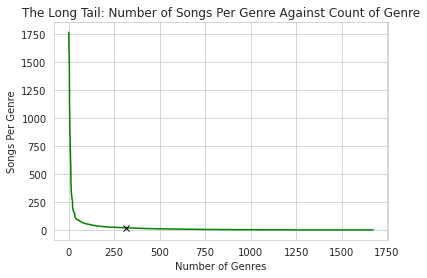

In [ ]:
#Show long tail to emphasize that a few genres make up a ton of the songs
y= (sorted(dict.values(),reverse=True))

#Plot table contents
plt.plot(y, color="green")

#Add title and axes
plt.title("The Long Tail: Number of Songs Per Genre Against Count of Genre")
plt.xlabel("Number of Genres")
plt.ylabel("Songs Per Genre")

#Add a point to show the where our cutoff sits on the long tail
plt.plot(len(table_above_avg),min(table_above_avg['Songs Including Genre']),'x', color='black')

#Add a horizontal line to show where our threshold intersects with the broader chart
plt.show()

In [ ]:
#Create new predictors for the top 10 genres for hits and other valuable insights

top_genres = table_above_avg["Genre"]
for g in top_genres:
    df[g] = 0
    df.loc[df['genres'].str.contains(g),g] = 1

#create ratio for position on album
df['position_on_album_ratio'] = df.track_number / df.album_tracks

#convert ms to seconds
df["duration_seconds"]=df["duration_ms"]/1000

df["chorus_hit_percent"]=(df["chorus_hit"])/(df["duration_seconds"])

#Last step is to drop irrelevant columns
df = df.drop(['genres', 'track', 'Unnamed: 0', 'uri', 'artist','duration_ms'], axis=1)
#We remove these columns because they are not actual predictors, are a copy of the index, or are used for some other transformation

In [ ]:
#Define numerical variables we should check for skew
skew_check = ["danceability","energy",	"loudness","speechiness","acousticness",	"instrumentalness",	"liveness","valence", "tempo",	"duration_seconds","chorus_hit_percent","chorus_hit","sections","track_number","album_tracks","position_on_album_ratio"]

df[skew_check].skew().sort_values()

loudness                  -2.666130
energy                    -0.860043
danceability              -0.382247
valence                    0.178443
position_on_album_ratio    0.270647
tempo                      0.323195
acousticness               1.450153
instrumentalness           1.626184
chorus_hit_percent         1.778256
chorus_hit                 2.042746
liveness                   2.238090
speechiness                2.370151
track_number               3.018350
duration_seconds           3.381844
sections                   3.435853
album_tracks               3.785306
dtype: float64

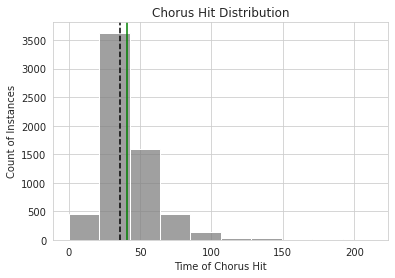

In [ ]:
#Draw a line for the mean and median of our dataset 
means = df['chorus_hit'].mean()
medians = df['chorus_hit'].median()

#Create a histogram to show our distribution
sns.histplot(df['chorus_hit'], color="grey",bins=10)

#Plot the lines onto the chart
plt.axvline(means, linestyle='solid', color="green")
plt.axvline(medians, linestyle='dashed', color='black')

#Add labels to the axes and title
plt.ylabel("Count of Instances")
plt.xlabel("Time of Chorus Hit")
plt.title("Chorus Hit Distribution")
plt.show()

In [ ]:
#Apply a sqrt transformation to the column
df['chorus_hit']=np.sqrt(df['chorus_hit'])

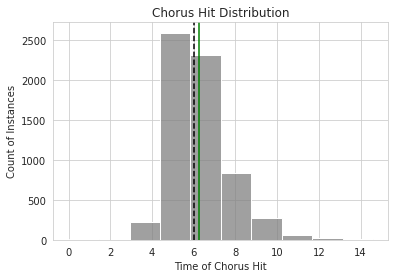

In [ ]:

means = df['chorus_hit'].mean()
medians = df['chorus_hit'].median()

sns.histplot(df['chorus_hit'], color="grey",bins=10)
plt.axvline(means, linestyle='solid', color="green")
plt.axvline(medians, linestyle='dashed', color='black')
plt.ylabel("Count of Instances")
plt.xlabel("Time of Chorus Hit")
plt.title("Chorus Hit Distribution")
plt.show()

In [ ]:
df['chorus_hit'].skew()

1.006078179331402

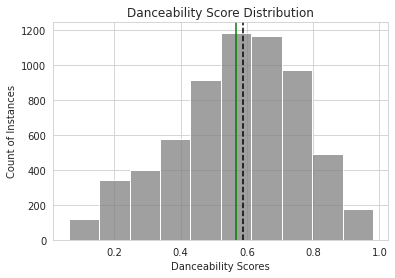

In [ ]:
means = df['danceability'].mean()
medians = df['danceability'].median()

sns.histplot(df['danceability'], color="grey",bins=10)
plt.axvline(means, linestyle='solid', color="green")
plt.axvline(medians, linestyle='dashed', color='black')
plt.ylabel("Count of Instances")
plt.xlabel("Danceability Scores")
plt.title("Danceability Score Distribution")
plt.show()

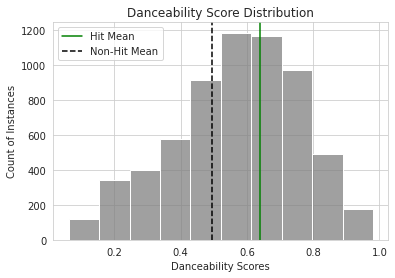

In [ ]:
# mean danceability of hits and non-hits
means = df.groupby('target')['danceability'].mean()
hit_means = means[1]
nonhit_means = means[0]
sns.histplot(df['danceability'], color="grey",bins=10)
plt.axvline(hit_means, linestyle='solid', color="green", label="Hit Mean")
plt.axvline(nonhit_means, linestyle='dashed', color='black', label="Non-Hit Mean")
plt.legend()
plt.ylabel("Count of Instances")
plt.xlabel("Danceability Scores")
plt.title("Danceability Score Distribution")
plt.show()

In [ ]:
df['danceability'].skew()

-0.3822465993857216

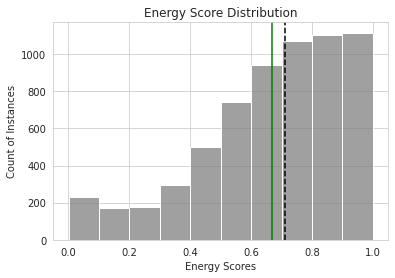

In [ ]:
means = df['energy'].mean()
medians = df['energy'].median()

sns.histplot(df['energy'], color="grey",bins=10)
plt.axvline(means, linestyle='solid', color="green")
plt.axvline(medians, linestyle='dashed', color='black')
plt.ylabel("Count of Instances")
plt.xlabel("Energy Scores")
plt.title("Energy Score Distribution")
plt.show()

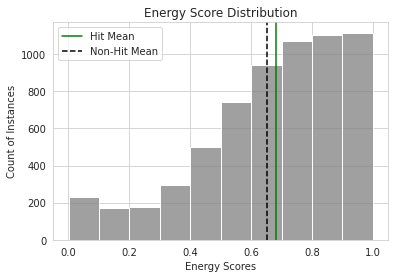

In [ ]:
means = df.groupby('target')['energy'].mean()
hit_means = means[1]
nonhit_means = means[0]

sns.histplot(df['energy'], color="grey",bins=10)
plt.axvline(hit_means, linestyle='solid', color="green", label="Hit Mean")
plt.axvline(nonhit_means, linestyle='dashed', color='black', label="Non-Hit Mean")
plt.legend()
plt.ylabel("Count of Instances")
plt.xlabel("Energy Scores")
plt.title("Energy Score Distribution")
plt.show()

In [ ]:
df['energy'].skew()

-0.8600426890619188

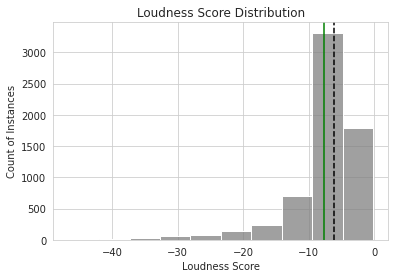

In [ ]:
means = df['loudness'].mean()
medians = df['loudness'].median()

sns.histplot(df['loudness'], color="grey",bins=10)
plt.axvline(means, linestyle='solid', color="green")
plt.axvline(medians, linestyle='dashed', color='black')
plt.ylabel("Count of Instances")
plt.xlabel("Loudness Score")
plt.title("Loudness Score Distribution")
plt.show()

In [ ]:
df['loudness'].skew()

-2.666130091875724

In [ ]:
df['loudness'] = np.log(1 + -df['loudness'])

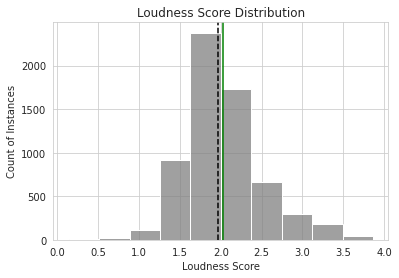

In [ ]:
means = df['loudness'].mean()
medians = df['loudness'].median()

sns.histplot(df['loudness'], color="grey",bins=10)
plt.axvline(means, linestyle='solid', color="green")
plt.axvline(medians, linestyle='dashed', color='black')
plt.ylabel("Count of Instances")
plt.xlabel("Loudness Score")
plt.title("Loudness Score Distribution")
plt.show()

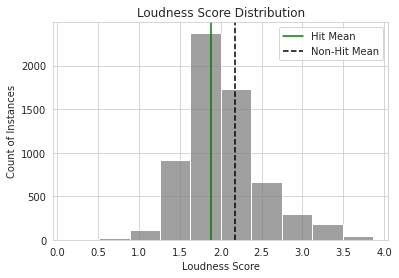

In [ ]:
# mean loudness of hits and non-hits
means = df.groupby('target')['loudness'].mean()
hit_means = means[1]
nonhit_means = means[0]
# true_mean = df['loudness'].mean()
sns.histplot(df['loudness'], color="grey",bins=10)
plt.axvline(hit_means, linestyle='solid', color="green", label="Hit Mean")
plt.axvline(nonhit_means, linestyle='dashed', color='black', label="Non-Hit Mean")
plt.legend()
# plt.axvline(true_mean, linestyle='solid', color="red", label="True mean")
plt.ylabel("Count of Instances")
plt.xlabel("Loudness Score")
plt.title("Loudness Score Distribution")
plt.show()

In [ ]:
df['loudness'].skew()

0.7790149742905728

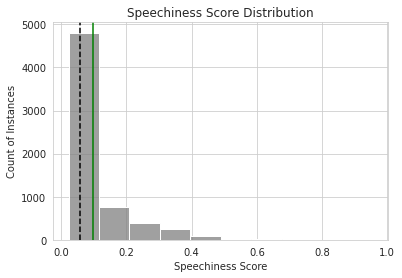

In [ ]:
means = df['speechiness'].mean()
medians = df['speechiness'].median()

sns.histplot(df['speechiness'], color="grey",bins=10)
plt.axvline(means, linestyle='solid', color="green")
plt.axvline(medians, linestyle='dashed', color='black')
plt.ylabel("Count of Instances")
plt.xlabel("Speechiness Score")
plt.title("Speechiness Score Distribution")
plt.show()

In [ ]:
df['speechiness'].skew()

2.3701514940341606

In [ ]:
df['speechiness'] = 1/df['speechiness']

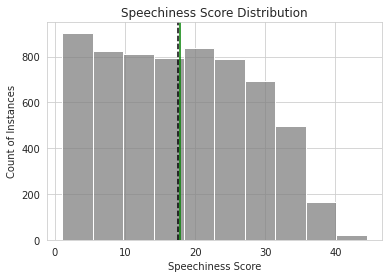

In [ ]:
means = df['speechiness'].mean()
medians = df['speechiness'].median()

sns.histplot(df['speechiness'], color="grey",bins=10)
plt.axvline(means, linestyle='solid', color="green")
plt.axvline(medians, linestyle='dashed', color='black')
plt.ylabel("Count of Instances")
plt.xlabel("Speechiness Score")
plt.title("Speechiness Score Distribution")
plt.show()

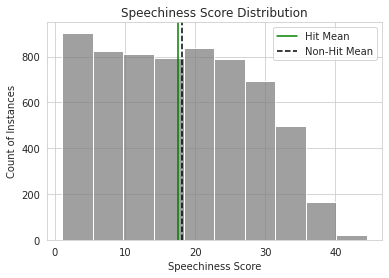

In [ ]:
# mean speechiness of hits and non-hits
means = df.groupby('target')['speechiness'].mean()
hit_means = means[1]
nonhit_means = means[0]

sns.histplot(df['speechiness'], color="grey",bins=10)
plt.axvline(hit_means, linestyle='solid', color="green", label="Hit Mean")
plt.axvline(nonhit_means, linestyle='dashed', color='black', label="Non-Hit Mean")
plt.legend()
plt.ylabel("Count of Instances")
plt.xlabel("Speechiness Score")
plt.title("Speechiness Score Distribution")
plt.show()

In [ ]:
df['speechiness'].skew()

0.17458054322810201

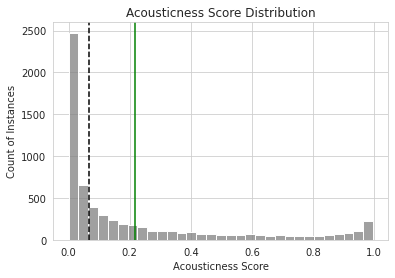

In [ ]:
means = df['acousticness'].mean()
medians = df['acousticness'].median()

sns.histplot(df['acousticness'], color="grey")
plt.axvline(means, linestyle='solid', color="green")
plt.axvline(medians, linestyle='dashed', color='black')
plt.ylabel("Count of Instances")
plt.xlabel("Acousticness Score")
plt.title("Acousticness Score Distribution")
plt.show()

In [ ]:
df['acousticness'].skew()

1.4501532583761902

In [ ]:
df['acousticness']=np.power(df['acousticness'],1/3)

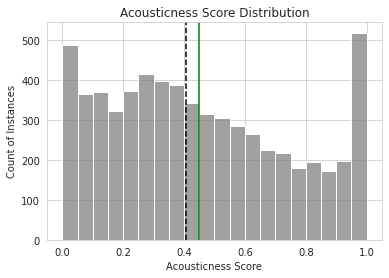

In [ ]:
means = df['acousticness'].mean()
medians = df['acousticness'].median()

sns.histplot(df['acousticness'], color="grey")
plt.axvline(means, linestyle='solid', color="green")
plt.axvline(medians, linestyle='dashed', color='black')
plt.ylabel("Count of Instances")
plt.xlabel("Acousticness Score")
plt.title("Acousticness Score Distribution")
plt.show()

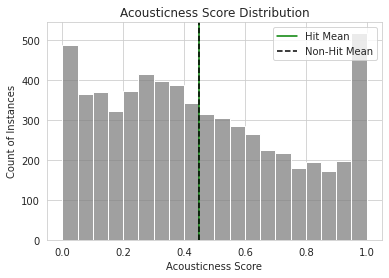

In [ ]:
# mean acousticness of hits and non-hits
means = df.groupby('target')['acousticness'].mean()
hit_means = means[1]
nonhit_means = means[0]

sns.histplot(df['acousticness'], color="grey")
plt.axvline(hit_means, linestyle='solid', color="green", label="Hit Mean")
plt.axvline(nonhit_means, linestyle='dashed', color='black', label="Non-Hit Mean")
plt.legend()
plt.ylabel("Count of Instances")
plt.xlabel("Acousticness Score")
plt.title("Acousticness Score Distribution")
plt.show()

In [ ]:
df['acousticness'].skew()

0.33733698350728436

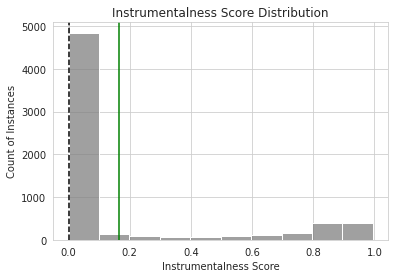

In [ ]:
means = df['instrumentalness'].mean()
medians = df['instrumentalness'].median()

sns.histplot(df['instrumentalness'], color="grey",bins=10)
plt.axvline(means, linestyle='solid', color="green")
plt.axvline(medians, linestyle='dashed', color='black')
plt.ylabel("Count of Instances")
plt.xlabel("Instrumentalness Score")
plt.title("Instrumentalness Score Distribution")
plt.show()

In [ ]:
df['instrumentalness'].skew()

1.6261839192900431

In [ ]:
df['instrumentalness']=np.power(df['instrumentalness'],1/4)

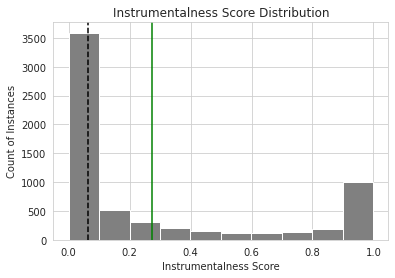

In [ ]:
means = df['instrumentalness'].mean()
medians = df['instrumentalness'].median()

df.hist("instrumentalness",color="grey")
plt.axvline(means, linestyle='solid', color="green")
plt.axvline(medians, linestyle='dashed', color='black')
plt.ylabel("Count of Instances")
plt.xlabel("Instrumentalness Score")
plt.title("Instrumentalness Score Distribution")
plt.show()

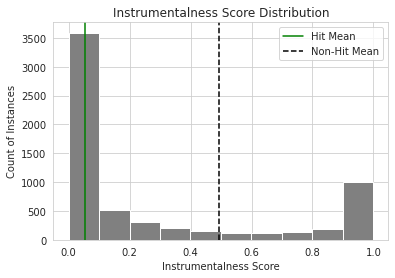

In [ ]:
# mean instrumentalness of hits and non-hits
means = df.groupby('target')["instrumentalness"].mean()
hit_means = means[1]
nonhit_means = means[0]

df.hist("instrumentalness",color="grey")
plt.axvline(hit_means, linestyle='solid', color="green",label="Hit Mean")
plt.axvline(nonhit_means, linestyle='dashed', color='black', label="Non-Hit Mean")
plt.legend()

plt.ylabel("Count of Instances")
plt.xlabel("Instrumentalness Score")
plt.title("Instrumentalness Score Distribution")
plt.show()

In [ ]:
df['instrumentalness'].skew()

1.061716319658064

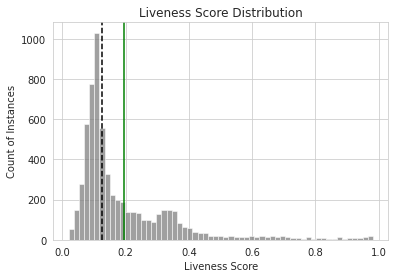

In [ ]:
means = df['liveness'].mean()
medians = df['liveness'].median()

sns.histplot(df['liveness'], color="grey")
plt.axvline(means, linestyle='solid', color="green")
plt.axvline(medians, linestyle='dashed', color='black')
plt.ylabel("Count of Instances")
plt.xlabel("Liveness Score")
plt.title("Liveness Score Distribution")
plt.show()

In [ ]:
df['liveness'].skew()

2.238090085583697

In [ ]:
df['liveness'] = -1*np.log(df['liveness']
                           )

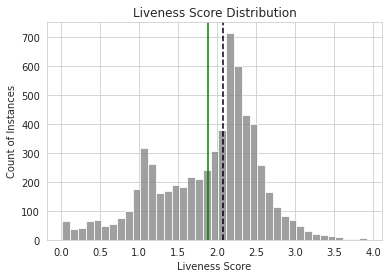

In [ ]:
means = df['liveness'].mean()
medians = df['liveness'].median()

sns.histplot(df['liveness'], color="grey")
plt.axvline(means, linestyle='solid', color="green")
plt.axvline(medians, linestyle='dashed', color='black')
plt.ylabel("Count of Instances")
plt.xlabel("Liveness Score")
plt.title("Liveness Score Distribution")
plt.show()

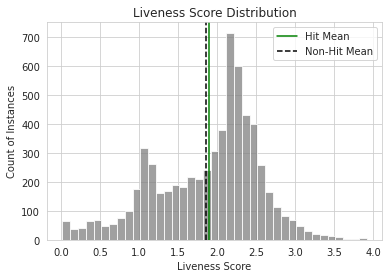

In [ ]:
# mean liveness of hits and non-hits
means = df.groupby('target')["liveness"].mean()
hit_means = means[1]
nonhit_means = means[0]

sns.histplot(df['liveness'], color="grey")
plt.axvline(hit_means, linestyle='solid', color="green", label ="Hit Mean")
plt.axvline(nonhit_means, linestyle='dashed', color='black', label="Non-Hit Mean")
plt.legend()
plt.ylabel("Count of Instances")
plt.xlabel("Liveness Score")
plt.title("Liveness Score Distribution")
plt.show()

In [ ]:
df['liveness'].skew()

-0.5270663273772214

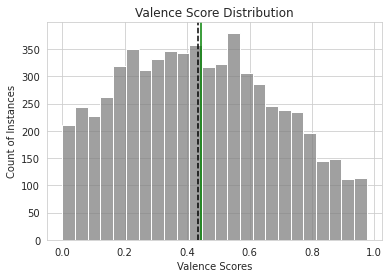

In [ ]:
means = df['valence'].mean()
medians = df['valence'].median()

sns.histplot(df['valence'], color="grey")
plt.axvline(means, linestyle='solid', color="green")
plt.axvline(medians, linestyle='dashed', color='black')
plt.ylabel("Count of Instances")
plt.xlabel("Valence Scores")
plt.title("Valence Score Distribution")
plt.show()

In [ ]:
df['valence'].skew()

0.1784427040544861

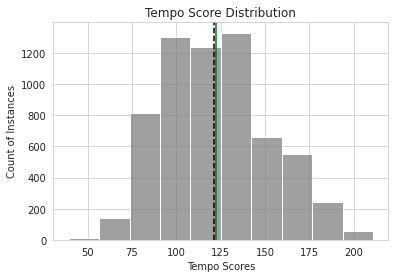

In [ ]:
means = df['tempo'].mean()
medians = df['tempo'].median()

sns.histplot(df['tempo'], color="grey",bins=10)
plt.axvline(means, linestyle='solid', color="green")
plt.axvline(medians, linestyle='dashed', color='black')
plt.ylabel("Count of Instances")
plt.xlabel("Tempo Scores")
plt.title("Tempo Score Distribution")
plt.show()

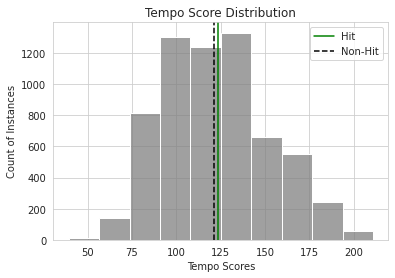

In [ ]:
# mean tempo of hits and non-hits
means = df.groupby('target')["tempo"].mean()
hit_means = means[1]
nonhit_means = means[0]

sns.histplot(df['tempo'], color="grey",bins=10)
plt.axvline(hit_means, linestyle='solid', color="green", label="Hit")
plt.axvline(nonhit_means, linestyle='dashed', color='black', label="Non-Hit")
plt.legend()
plt.ylabel("Count of Instances")
plt.xlabel("Tempo Scores")
plt.title("Tempo Score Distribution")
plt.show()

In [ ]:
df['tempo'].skew()

0.3231945071134466

In [ ]:
df['duration_seconds'].skew()

3.381843784896678

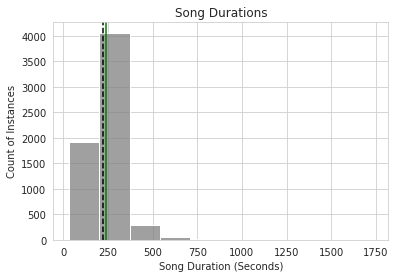

In [ ]:
means = df['duration_seconds'].mean()
medians = df['duration_seconds'].median()

sns.histplot(df['duration_seconds'], color="grey",bins=10)
plt.title("Song Durations")
plt.axvline(means, linestyle='solid', color="green")
plt.axvline(medians, linestyle='dashed', color='black')
plt.ylabel("Count of Instances")
plt.xlabel("Song Duration (Seconds)")
plt.show()

In [ ]:
df['duration_seconds'] = np.log(df['duration_seconds'])

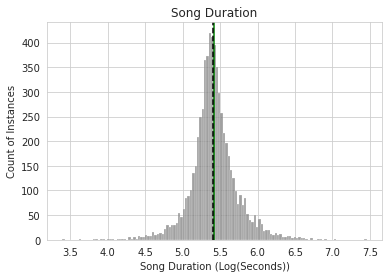

In [ ]:
means = df['duration_seconds'].mean()
medians = df['duration_seconds'].median()

sns.histplot(df['duration_seconds'], color="grey")
plt.axvline(means, linestyle='solid', color="green")
plt.axvline(medians, linestyle='dashed', color='black')
plt.ylabel("Count of Instances")
plt.xlabel("Song Duration (Log(Seconds))")
plt.title("Song Duration")
plt.show()

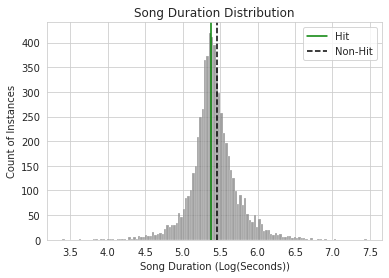

In [ ]:
# mean duration of hits and non-hits
means = df.groupby('target')["duration_seconds"].mean()
hit_means = means[1]
nonhit_means = means[0]

sns.histplot(df['duration_seconds'], color="grey")
plt.axvline(hit_means, linestyle='solid', color="green",label="Hit")
plt.axvline(nonhit_means, linestyle='dashed', color='black', label="Non-Hit")
plt.legend()
plt.ylabel("Count of Instances")
plt.xlabel("Song Duration (Log(Seconds))")
plt.title("Song Duration Distribution")
plt.show()

In [ ]:
df['duration_seconds'].skew()

0.13123500864052176

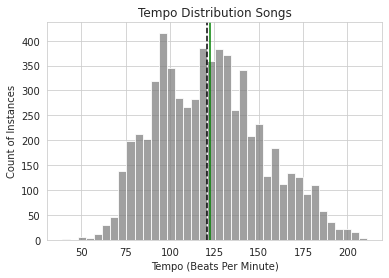

In [ ]:
means = df['tempo'].mean()
medians = df['tempo'].median()

sns.histplot(df['tempo'], color="grey")
plt.axvline(means, linestyle='solid', color="green")
plt.axvline(medians, linestyle='dashed', color='black')
plt.ylabel("Count of Instances")
plt.xlabel("Tempo (Beats Per Minute)")
plt.title("Tempo Distribution Songs")
plt.show()

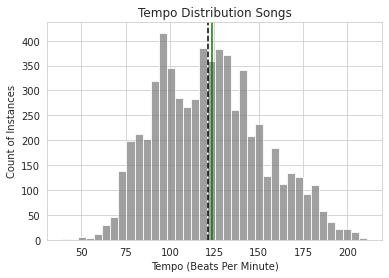

In [ ]:
# mean tempo of hits and non-hits
means = df.groupby('target')["tempo"].mean()
hit_means = means[1]
nonhit_means = means[0]

sns.histplot(df['tempo'], color="grey")
plt.axvline(hit_means, linestyle='solid', color="green", label="Hit")
plt.axvline(nonhit_means, linestyle='dashed', color='black', label="Non-Hit")
plt.ylabel("Count of Instances")
plt.xlabel("Tempo (Beats Per Minute)")
plt.title("Tempo Distribution Songs")
plt.show()

In [ ]:
means = df['tempo'].skew()

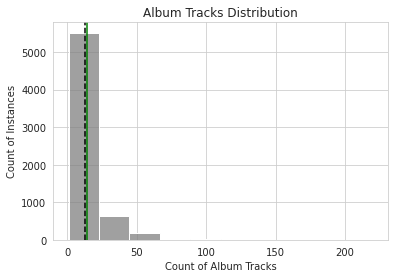

In [ ]:
means = df['album_tracks'].mean()
medians = df['album_tracks'].median()

sns.histplot(df['album_tracks'], color="grey",bins=10)
plt.axvline(means, linestyle='solid', color="green")
plt.axvline(medians, linestyle='dashed', color='black')
plt.ylabel("Count of Instances")
plt.xlabel("Count of Album Tracks")
plt.title("Album Tracks Distribution")
plt.show()

In [ ]:
df['album_tracks']=np.log(1+df['album_tracks'])

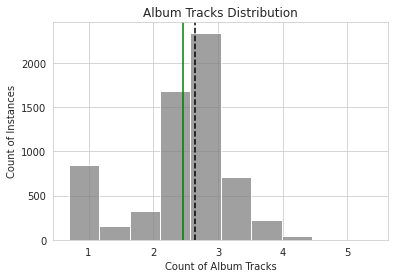

In [ ]:
means = df['album_tracks'].mean()
medians = df['album_tracks'].median()

sns.histplot(df['album_tracks'], color="grey",bins=10)
plt.axvline(means, linestyle='solid', color="green")
plt.axvline(medians, linestyle='dashed', color='black')
plt.ylabel("Count of Instances")
plt.xlabel("Count of Album Tracks")
plt.title("Album Tracks Distribution")
plt.show()

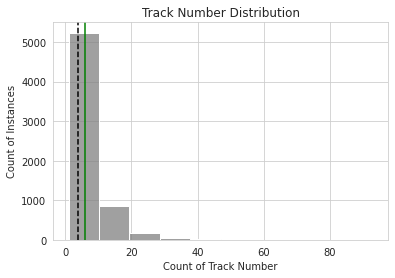

In [ ]:
means = df['track_number'].mean()
medians = df['track_number'].median()

sns.histplot(df['track_number'], color="grey",bins=10)
plt.axvline(means, linestyle='solid', color="green")
plt.axvline(medians, linestyle='dashed', color='black')
plt.ylabel("Count of Instances")
plt.xlabel("Count of Track Number")
plt.title("Track Number Distribution")
plt.show()

In [ ]:
df['track_number']=np.log(1+df['track_number'])

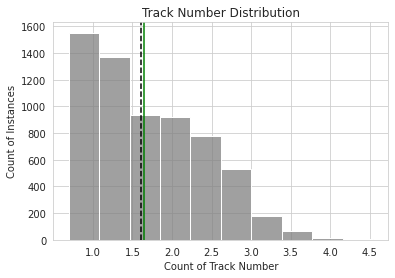

In [ ]:
means = df['track_number'].mean()
medians = df['track_number'].median()

sns.histplot(df['track_number'], color="grey",bins=10)
plt.axvline(means, linestyle='solid', color="green")
plt.axvline(medians, linestyle='dashed', color='black')
plt.ylabel("Count of Instances")
plt.xlabel("Count of Track Number")
plt.title("Track Number Distribution")
plt.show()

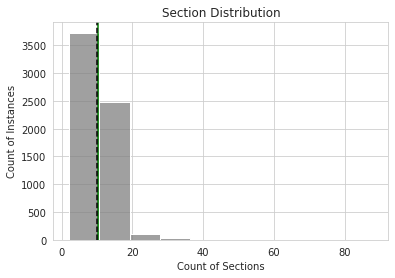

In [ ]:
means = df['sections'].mean()
medians = df['sections'].median()

sns.histplot(df['sections'], color="grey",bins=10)
plt.axvline(means, linestyle='solid', color="green")
plt.axvline(medians, linestyle='dashed', color='black')
plt.ylabel("Count of Instances")
plt.xlabel("Count of Sections")
plt.title("Section Distribution")
plt.show()

In [ ]:
df['sections']=np.log(1+df['sections'])

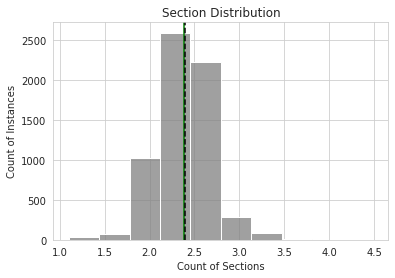

In [ ]:
means = df['sections'].mean()
medians = df['sections'].median()

sns.histplot(df['sections'], color="grey",bins=10)
plt.axvline(means, linestyle='solid', color="green")
plt.axvline(medians, linestyle='dashed', color='black')
plt.ylabel("Count of Instances")
plt.xlabel("Count of Sections")
plt.title("Section Distribution")
plt.show()

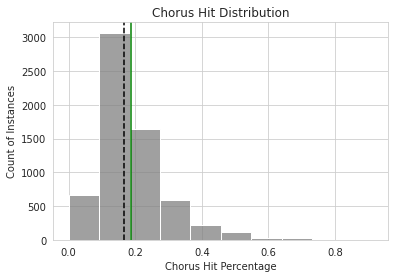

In [ ]:
means = df['chorus_hit_percent'].mean()
medians = df['chorus_hit_percent'].median()

sns.histplot(df['chorus_hit_percent'], color="grey",bins=10)
plt.axvline(means, linestyle='solid', color="green")
plt.axvline(medians, linestyle='dashed', color='black')
plt.ylabel("Count of Instances")
plt.xlabel("Chorus Hit Percentage")
plt.title("Chorus Hit Distribution")
plt.show()

In [ ]:
df['chorus_hit_percent']=np.log(1+df['sections'])

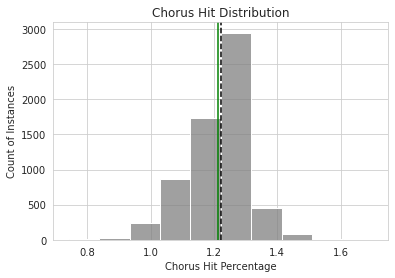

In [ ]:
means = df['chorus_hit_percent'].mean()
medians = df['chorus_hit_percent'].median()

sns.histplot(df['chorus_hit_percent'], color="grey",bins=10)
plt.axvline(means, linestyle='solid', color="green")
plt.axvline(medians, linestyle='dashed', color='black')
plt.ylabel("Count of Instances")
plt.xlabel("Chorus Hit Percentage")
plt.title("Chorus Hit Distribution")
plt.show()

In [ ]:
#Define numerical variables we should check for skew
skew_check = ["danceability","energy",	"loudness","speechiness","acousticness",	"instrumentalness",	"liveness","valence", "tempo",	"duration_seconds","chorus_hit_percent","chorus_hit","sections","track_number","album_tracks","position_on_album_ratio"]

df[skew_check].skew().sort_values()

album_tracks              -0.947025
energy                    -0.860043
liveness                  -0.527066
chorus_hit_percent        -0.414871
danceability              -0.382247
sections                   0.117247
duration_seconds           0.131235
speechiness                0.174581
valence                    0.178443
position_on_album_ratio    0.270647
tempo                      0.323195
acousticness               0.337337
track_number               0.373839
loudness                   0.779015
chorus_hit                 1.006078
instrumentalness           1.061716
dtype: float64

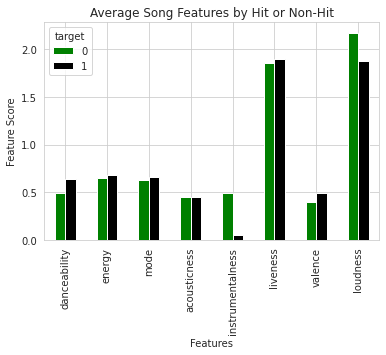

In [ ]:
#Song Features that are already on the same scale - we could normalize these + loudness to expand this later
cols = ['danceability',	'energy',	"mode",	"acousticness",	"instrumentalness",	"liveness",	"valence", 'loudness']
# ,'speechiness'
test = df.groupby(by="target")[cols].mean()
newframe = test.T
newframe.plot.bar(title='Average Song Features by Hit or Non-Hit', color=['green','black'])
plt.ylabel("Feature Score")
plt.xlabel("Features")
plt.show()

In [ ]:
#Plot Number of songs by album type
groups = df.groupby(by=['target','alb_type']).size()
unstacked_groups = groups.unstack(level=1)
unstacked_groups.plot(kind="bar", color=['green','gray','black'],title='Distribution of Hits and Non-Hits by Album Type')
plt.xticks([0,1],["Non-Hit","Hit"])
plt.ylabel("Songs in Genre")
plt.xlabel("Hit Status")
plt.show()

In [ ]:
#List hit rates by album type to build on previous chart - however, this seems misleading because it could be used to say 50/50 shot at hitting the top 100.
groups =df.groupby(by='alb_type')["target"].mean()
alb_types = ["album","compilation","single"]
# groups.plot.bar(color=["green","grey","black"],title="Hit Rates by Album Type")
plt.bar(alb_types,groups, color=["green","grey","black"])
plt.title("Hit Rates by Album Type")
plt.show()

In [ ]:

explicit =df.groupby(by=['target','explicit']).size()
unstacked_expl = explicit.unstack(level=1)
unstacked_expl.plot(kind="bar", color=['green','black'],title='Number of Hits for Explicit and Clean Songs')
plt.xticks([0,1],["Non-Hit","Hit"])
plt.ylabel("Number of Songs")
plt.xlabel("Hit Status")
plt.show()

In [ ]:
explicit = df.groupby(by='explicit')['target'].mean()
hits = ["Non-Hits", "Hits"]

plt.bar(hits,explicit,color=['green','black'])
plt.title('Hit Rates for Explicit and Clean Songs')
plt.show()

In [ ]:
#Beats per bar is the definition of time sig (so 1 per bar is a slower cadence than 5)
time_sig =df.groupby(by='time_signature')['target'].mean()
#Omit 0 since 0/n time is not a real thing
updated_time_sig = time_sig[1:]
updated_time_sig.plot.bar(color=["green","lightgrey","grey","black"],title="Rates of Hit Occurence by Time Signature")
plt.ylabel("Hit Rate (%)")
plt.xlabel("Time Signature (Beats per Measure)")
plt.xticks([0,1,2,3],["1","3","4","5"], rotation=0)
plt.show()

In [ ]:
df.boxplot(column='duration_seconds', by="target", showfliers=False, color="green")

#Add title 
plt.title("Boxplot of Song Duration by Hit Status")

#Add labels for class and axes 
plt.xticks([1,2],["Non-Hit","Hit"])
plt.ylabel("Song Duration (Seconds)")
plt.xlabel("Hit Status")
plt.suptitle("")
plt.show()

In [ ]:
#Create a boxplot for instrumentalness and sort by target 
df.boxplot(column='instrumentalness', by="target", showfliers=False, color="green")

#Add title 
plt.title("Comparison of Instrumentalness Means Between Hits and Non-Hits")

#Add ticks for hit status
plt.xticks([1,2],["Non-Hit","Hit"])

#Add labels
plt.ylabel("Instrumentalness")
plt.xlabel("Hit Status")
plt.suptitle("")
plt.show()

In [ ]:
df = df.drop(['main_popularities','main_followers','feature_popularities','feature_followers'], axis=1)

In [ ]:
#Since these numerical variables were in the original dataset, test these for correlation and see if they would be worth exploring for polynomial features
df1 = df[['danceability',	'energy',	"mode",	"acousticness",	"instrumentalness",	"liveness",	"valence", 'loudness']]

#Create a correlation matrix in seaborn
corrMatrix = df1.corr()
sns.heatmap(corrMatrix, annot=True,cmap="Greens")

#Add a title
plt.title("Song Features Correlation Matrix")
plt.show()

In [ ]:
df.to_csv('/content/drive/MyDrive/BA476/data/Manipulated_data.csv')